In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
from functools import reduce
from tqdm import tqdm
from nltk.stem.snowball import SnowballStemmer

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [2]:
import gc
gc.collect()

0

In [3]:
with open('feedback.csv', 'r') as file:
    lines = file.readlines()
    lines = [line[:-1] for line in lines]
    cols = lines[0].split(',')
    lines = lines[1:]
    lines = [line.split(',') for line in lines]
    lines = [[*line[:4], " ".join(line[4:])] for line in lines]

dataset = pd.DataFrame(lines, columns=cols)

In [4]:
dataset.head()

,rating,product_id,name,date,feedback
0,1,8342,Александр,2017-04-12,"""6 входов предохранитель"" ""искрит при включен..."
1,5,8342,Елена,2015-08-04,"""Я являюсь пользователем Пилотов уже больше 10..."
2,5,5311,Леонид,2017-07-16,"""хорошо мелет"" ""маркий остаются следы"" ""Испол..."
3,4,5311,Сергей,2017-06-28,"Компактная ""Не нашел"" ""Работает на ура. В инст..."
4,5,5311,Ольга,2017-01-21,"""Цена и качество"" Нет ""В использовании 2 месяц..."


In [5]:
def process_feedback(text: str):
    text = text.replace(',', ' ')
    return ''.join([c if c.isdigit() or c.isalpha() else ' ' for c in text.lower()])

dataset['feedback'] = dataset['feedback'].apply(process_feedback)
dataset['rating'] = dataset['rating'].astype(float)

In [6]:
dataset.head()

,rating,product_id,name,date,feedback
0,1.0,8342,Александр,2017-04-12,6 входов предохранитель искрит при включен...
1,5.0,8342,Елена,2015-08-04,я являюсь пользователем пилотов уже больше 10...
2,5.0,5311,Леонид,2017-07-16,хорошо мелет маркий остаются следы испол...
3,4.0,5311,Сергей,2017-06-28,компактная не нашел работает на ура в инст...
4,5.0,5311,Ольга,2017-01-21,цена и качество нет в использовании 2 месяц...


In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset['feedback'], dataset['rating'], test_size=0.3)

# Stemming + word encoding

In [41]:
from itertools import chain


def stem(data):
    stemmer = SnowballStemmer('russian')
    return data.apply(lambda text: [stemmer.stem(word) for word in text.split(' ')])

def clear_words(data):
    return data.apply(lambda l: [word for word in l if word.isalpha()])

def encode_words(train, test):
    train = clear_words(train)
    test = clear_words(test)
    
    words = reduce(lambda x, y: set(x).union(set(y)), chain(train, test))
    words_map = {word: i + 2 for i, word in enumerate(words)}
    print(len(words) + 2) 
    
    mapping_func = lambda l: [words_map[word] for word in l] + [0]
    return train.apply(mapping_func), test.apply(mapping_func)

def equalize(train, test, length):
    eq_func = lambda l: l[:length] if len(l) >= length else l + [1] * (length - len(l))
    return train.apply(eq_func), test.apply(eq_func)

def clear_zero_lengths(data):
    return data.where(data.apply(len) != 0)

def to_array(series):
    return np.array(list(series.values))

In [9]:
X_train_stem = stem(X_train)
X_test_stem = stem(X_test)

In [42]:
X_train_encoded, X_test_encoded = encode_words(X_train_stem, X_test_stem)

25816


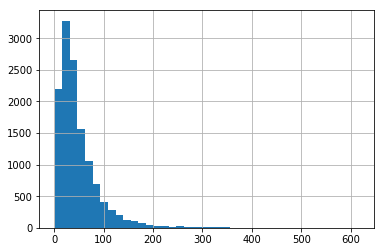

In [43]:
X_train_encoded.apply(len).hist(bins=40)

In [44]:
X_train_encoded.apply(len).median(), X_test_encoded.apply(len).median()

(37.0, 36.0)

In [45]:
X_train_tr, X_test_tr = equalize(X_train_encoded, X_test_encoded, length=256)

In [46]:
X_train_final = to_array(X_train_tr)
X_test_final = to_array(X_test_tr)

# Bidirectional LSTM (continious target)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [48]:
model = tf.keras.Sequential()
model.add(Embedding(25816, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss=tf.keras.losses.mean_squared_error, metrics=[tf.keras.metrics.mean_squared_error])
model.fit(X_train_final, y_train, batch_size=128, epochs=4, validation_split=0.1)

Train on 11555 samples, validate on 1284 samples
Epoch 1/4
11555/11555 [==============================] - 86s 7ms/sample - loss: 2.0031 - mean_squared_error: 2.0031 - val_loss: 1.0864 - val_mean_squared_error: 1.0864
Epoch 2/4
11555/11555 [==============================] - 84s 7ms/sample - loss: 0.8968 - mean_squared_error: 0.8968 - val_loss: 0.8681 - val_mean_squared_error: 0.8681
Epoch 3/4
11555/11555 [==============================] - 83s 7ms/sample - loss: 0.5702 - mean_squared_error: 0.5702 - val_loss: 0.8785 - val_mean_squared_error: 0.8785
Epoch 4/4
11555/11555 [==============================] - 82s 7ms/sample - loss: 0.4433 - mean_squared_error: 0.4433 - val_loss: 0.8592 - val_mean_squared_error: 0.8592


In [49]:
predictions = model.predict(X_test_final)
mean_squared_error(predictions, y_test)

0.9129527709337447

In [50]:
print(classification_report(y_test.round().astype('int'), predictions.round().astype('int')))
accuracy_score(y_test.round().astype('int'), predictions.round().astype('int'))

              precision    recall  f1-score   support

           1       0.53      0.26      0.35       521
           2       0.20      0.33      0.25       314
           3       0.20      0.23      0.22       447
           4       0.26      0.34      0.29       924
           5       0.83      0.77      0.80      3297

   micro avg       0.58      0.58      0.58      5503
   macro avg       0.41      0.39      0.38      5503
weighted avg       0.62      0.58      0.59      5503



0.5785934944575686

# Bidirectional LSTM (multiclass target)

In [51]:
y_train_ohe = OneHotEncoder().fit_transform(y_train.round().astype('int').reshape(-1, 1)).todense()
y_test_ohe = OneHotEncoder().fit_transform(y_test.round().astype('int').reshape(-1, 1)).todense()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  
/usr/

In [52]:
model = tf.keras.Sequential()
model.add(Embedding(28557, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.005), loss=tf.keras.losses.categorical_crossentropy, metrics=['accuracy'])
model.fit(X_train_final, y_train_ohe, batch_size=128, epochs=3, validation_split=0.1)

Train on 11555 samples, validate on 1284 samples
Epoch 1/3
11555/11555 [==============================] - 84s 7ms/sample - loss: 1.0461 - accuracy: 0.6168 - val_loss: 0.8824 - val_accuracy: 0.6542
Epoch 2/3
11555/11555 [==============================] - 83s 7ms/sample - loss: 0.7723 - accuracy: 0.7032 - val_loss: 0.8920 - val_accuracy: 0.6480
Epoch 3/3
11555/11555 [==============================] - 83s 7ms/sample - loss: 0.5872 - accuracy: 0.7797 - val_loss: 0.9577 - val_accuracy: 0.6410


In [53]:
predictions = model.predict(X_test_final).argmax(axis=1) + 1

In [54]:
print(classification_report(y_test.round().astype('int'), predictions))
accuracy_score(y_test.round().astype('int'), predictions)

              precision    recall  f1-score   support

           1       0.49      0.51      0.50       521
           2       0.22      0.06      0.09       314
           3       0.27      0.13      0.17       447
           4       0.31      0.47      0.37       924
           5       0.81      0.80      0.80      3297

   micro avg       0.62      0.62      0.62      5503
   macro avg       0.42      0.39      0.39      5503
weighted avg       0.62      0.62      0.61      5503



0.6180265309831001

# Bidirectional LSTM (binary target)

In [55]:
y_train_bin = (y_train.round() > 3).astype('int')
y_test_bin = (y_test.round() > 3).astype('int')

In [59]:
model = tf.keras.Sequential()
model.add(Embedding(28557, 128))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01), loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'])
model.fit(X_train_final, y_train_bin, batch_size=64, epochs=3, validation_split=0.2)

Train on 10271 samples, validate on 2568 samples
Epoch 1/3
10271/10271 [==============================] - 98s 10ms/sample - loss: 0.4115 - accuracy: 0.8258 - val_loss: 0.3358 - val_accuracy: 0.8575
Epoch 2/3
10271/10271 [==============================] - 100s 10ms/sample - loss: 0.2275 - accuracy: 0.9170 - val_loss: 0.3436 - val_accuracy: 0.8621
Epoch 3/3
10271/10271 [==============================] - 100s 10ms/sample - loss: 0.1196 - accuracy: 0.9605 - val_loss: 0.4021 - val_accuracy: 0.8567


In [60]:
predictions = model.predict(X_test_final)

In [61]:
print(classification_report(y_test_bin, predictions > 0.5))
print(roc_auc_score(y_test_bin, predictions))
print(accuracy_score(y_test_bin, predictions > 0.5))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66      1282
           1       0.88      0.95      0.91      4221

   micro avg       0.86      0.86      0.86      5503
   macro avg       0.82      0.76      0.78      5503
weighted avg       0.85      0.86      0.85      5503

0.8971338242300124
0.8597128838815191
